## Mangrove change analysis
- static GMW vectors (for now until the geoserver option works)
- select where you want to be in PNG (could change later to geojson input)
- select years of GMW to compare (d/l from here - https://data.unep-wcmc.org/datasets/45 - for now until the geoserver option works)
- load in vector layers of AOI extent only
- rasterise
- compute change analysis
- display similar to interactive WOfS where distribution is seen?

#### Load packages

In [1]:
import matplotlib.pyplot as plt

import sys
import numpy as np
import xarray as xr
import geopandas as gpd

import datacube
from dea_tools.spatial import xr_rasterize
from dea_tools.plotting import display_map

dc = datacube.Datacube(app='Mangrove change analysis')

/tmp/ipykernel_2724/147992147.py:6: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


#### AWS Access

In [2]:
## Optional: Access AWS "requester-pays" buckets
# This is necessary for Landsat ("landsatN_c2l2_*") and Sentinel-2 ("s2_l2a") products
from datacube.utils.aws import configure_s3_access
configure_s3_access(aws_unsigned=False, requester_pays=True);

#### display AOI

In [3]:
latitude = (-7.3, -7.4)
longitude = (144.4, 144.5)
display_map(longitude, latitude)

/env/lib/python3.10/site-packages/dea_tools/plotting.py:313: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  all_longitude, all_latitude = transform(Proj(crs), Proj('EPSG:4326'), all_x,


#### load GMW and datacube AOI

In [4]:
# path to GMW layer
gmw_2020 = '../data/gmw_v3_2020_vec.shp'

# load in mangrove vector data just for AOI extent
bbox = [longitude[0], latitude[1], longitude[1], latitude[0]]

gmw_vec = gpd.read_file(gmw_2020, bbox=bbox)

/env/lib/python3.10/site-packages/pygeos/io.py:89: UserWarning: The shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the PyGEOS GEOS version (3.10.2-CAPI-1.16.0). Conversions between both will be slow
  warnings.warn(


In [5]:
# load in some datacube data (to get xarray features to rasterise polygon AOI to)

# set time range
time = ('2020-01-01', '2020-01-31')


# load data
ds = dc.load(
    product = 'landsat8_c2l2_sr', 
    latitude = latitude,
    longitude = longitude,
    time=time,
    measurements=['blue', 'green', 'red', 'nir08', 'swir16', 'swir22', 'qa_pixel'],
    output_crs="EPSG:32755",  # Target CRS - https://epsg.io/?q=Papua%20New%20Guinea%20kind%3APROJCRS
    resolution=(30, -30),     # Target resolution
    group_by='solar_day',     # Group by time method
    dask_chunks={'time': 1, 'x': 100, 'y': 100}
)

# rename bands, needed for rgb function and for xr_geomedian
ds = ds.rename({
    "blue": "nbart_blue",
    "green": "nbart_green",
    "red": "nbart_red",
    "nir08": "nbart_nir",
    "swir16": "nbart_swir_1",
    "swir22": "nbart_swir_2",
    "qa_pixel": "fmask",
})

ds

# select out only 1 time step to use in xr_rasterize
ds_AOI = ds.isel(time=0)

In [6]:
# Subset the vector geometries to the area of interest
xmin, ymin, xmax, ymax = bbox
gmw_vec_geom = gmw_vec.cx[xmin:xmax, ymin:ymax]

In [8]:
AOI_mangrove = xr_rasterize(gdf=gmw_vec_geom, da=ds_AOI)

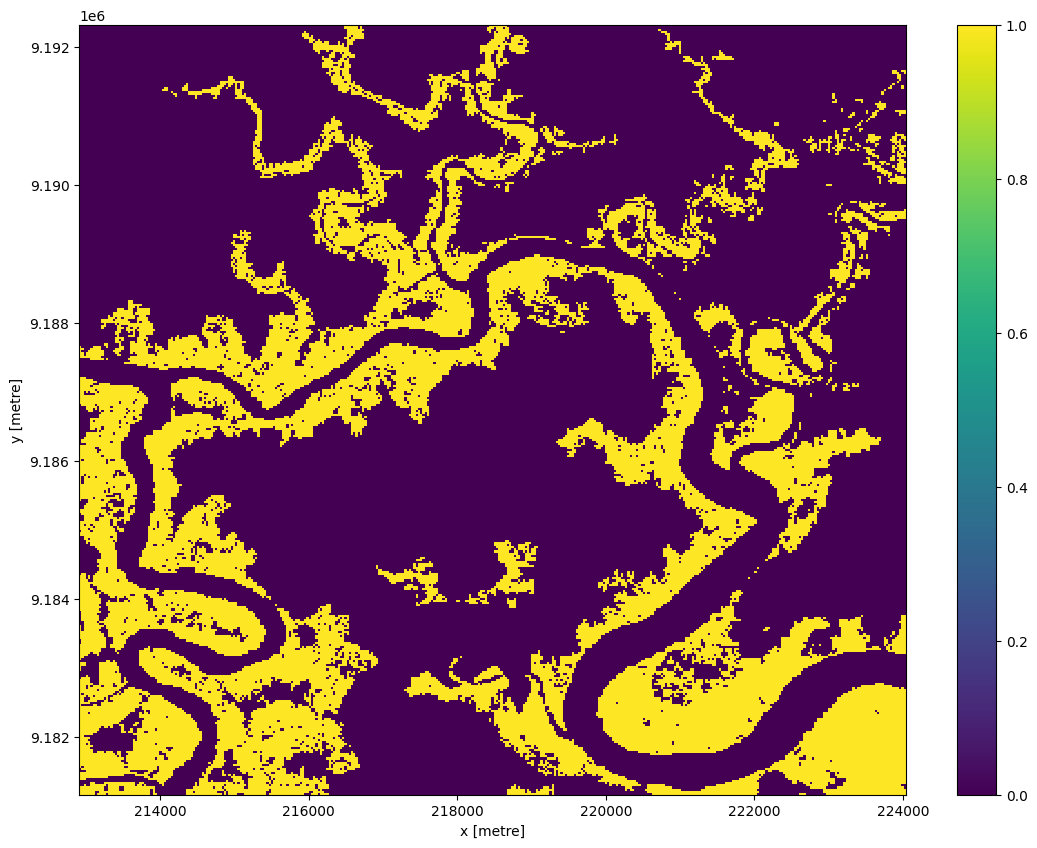

In [11]:
AOI_mangrove.plot(size=10)